In [2]:
import numpy as np
import torch
from torch.distributions.normal import Normal

import pyro
import pyro.distributions as dist

from generation_with_evaluation_period import generative_procedure_with_evaluation_period
import kalman_filter

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
L = 500
L_train = 350
S = 7

sigma_e = 0.1 
sigma_u = 0.1
sigma_v = 0.0004 
sigma_w = 0.01 
sigma_r = 1. 
sigma_o = 4.

mu_0 = 20.
delta_0 = 0.

gamma_0 = np.array([1,2,4,-1,-3,-2]) / 10
p_c = 4 / 350
p_a = 10 / 350

t_c_fixed = 330 - 1
c_fixed = 1.
t_r_fixed = 330 - 1
r_fixed = 2.

In [4]:
torch.manual_seed(4)
y, _, _, _, _, _, _, z_a, z_c = generative_procedure_with_evaluation_period(mu_0, delta_0, gamma_0, 
                                                                        sigma_e, sigma_o, sigma_u, 
                                                                        sigma_r, sigma_v, sigma_w, 
                                                                        p_a, p_c, L, L_train, S, 
                                                                        t_c_fixed, c_fixed, t_r_fixed, r_fixed)

m = S + 1
r = 3

a_1 = kalman_filter.gen_a_1(S, y)
P_1 = kalman_filter.gen_P_1(S, 10e7)

Z_t = kalman_filter.gen_Z_t(S)
T_t = kalman_filter.gen_T_t(S)
R_t = kalman_filter.gen_R_t(S)

H_e = sigma_e ** 2
H_o = sigma_o ** 2

Q_eta = kalman_filter.gen_Q_eta(sigma_r, sigma_v, sigma_w)
Q_xi = kalman_filter.gen_Q_eta(sigma_u, sigma_v, sigma_w)

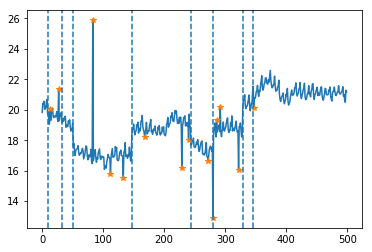

In [5]:
plt.figure()
plt.plot(np.array(y))
plt.plot(np.array(torch.nonzero(z_a)),np.array(y[torch.nonzero(z_a)]), '*')
for c in torch.nonzero(z_c):
    plt.axvline(x=c, linestyle='--')

In [6]:
a, P = kalman_filter.kalman_filter(L_train, m, y, a_1, P_1, Z_t, p_a, p_c, T_t, H_e, H_o, Q_eta, Q_xi, R_t)

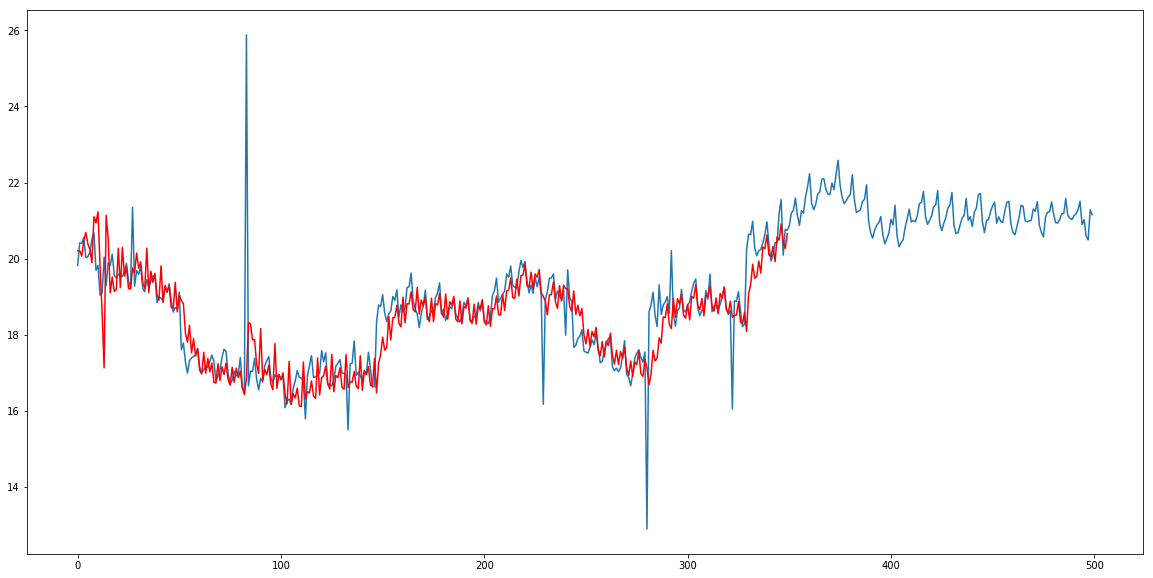

In [11]:
y_t = []
for i in a:
    y_t.append(Z_t @ i)

plt.figure(figsize=(20,10))
plt.plot(np.array(y))
plt.plot(np.array(y_t), color='r')